## Importação das bibliotecas

In [1]:

import os
import numpy as np
import rasterio
from rasterio.mask import mask
import openeo
import json
import time
from datetime import datetime, timedelta
import requests
import subprocess
import os
import json
import openeo
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import sys
import rasterio
from rasterio.features import geometry_mask
from rasterio.mask import mask
import geopandas as gpd
import xarray
import matplotlib.pyplot as plt
import pandas as pd
import rioxarray as rio

## Conexão com o serviço OpenEO

In [5]:
# Conectando ao serviço OpenEO
# Aqui, precisei fazer login no site. Isso me permitiu autenticar
connection = openeo.connect("openeo.dataspace.copernicus.eu")
connection.authenticate_oidc_device(store_refresh_token=True)

# Aqui consigo verificar as informações da conexão (deve me retornar os meus dados de conta)
# connection.describe_account() 

Visit https://identity.dataspace.copernicus.eu/auth/realms/CDSE/device?user_code=VRMI-ANUA 📋 to authenticate.

✅ Authorized successfully

<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

## Definição da região e período de estudo 

In [84]:
# Aqui, você deve escrever o ano, mês e dia em que ocorreu o deslizamento de terra
ANO = 2022
MES = 2
DIA = 15
prod_dir = './sentinel2_10m'

In [ ]:
# Crie um arquivo geojson da região de interesse através do QGIS e EXPORTE EM EPSG 4326
# Carregando o arquivo GeoJSON
geojson_path = "./study_area/contorno_area_estudo.geojson"
with open(geojson_path) as f:
    geojson = json.load(f)
    
geom = geojson['features'][0]['geometry']

In [7]:
# Definindo a data do deslizamento
landslide_date = datetime.strptime(f"{ANO}-{MES}-{DIA}", "%Y-%m-%d")
landslide_date_str = landslide_date.strftime("%Y-%m-%d")

In [8]:
# O intervalo temporal abaixo permitirá extrair imagens no período anterior e posterior ao deslizamento
before_start_date = (landslide_date - timedelta(days=30)).strftime("%Y-%m-%d") # 30 dia antes 
after_end_date   = (landslide_date + timedelta(days=30)).strftime("%Y-%m-%d")    # 30 dias depois

In [85]:
# Diretório de saída para os arquivos TIFF
output_dir_NDVI = f"{prod_dir}/NDVI/"
output_dir_RGB = f"{prod_dir}/RGB/"


## Carregamento da coleção de imagens do período anterior e posterior ao deslizamento de terra

In [86]:
# Para saber o nome das bandas a extrair
satelite = 'SENTINEL2_L2A' # Diga aqui o satélite de interesse
collection_details = connection.describe_collection(satelite)

# Lista as bandas disponíveis
bands = [band['name'] for band in collection_details['summaries']['eo:bands']]
print(f"Bandas disponíveis na coleção {satelite}:")
print(bands)

Bandas disponíveis na coleção SENTINEL2_L2A:
['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'WVP', 'AOT', 'SCL', 'sunAzimuthAngles', 'sunZenithAngles', 'viewAzimuthMean', 'viewZenithMean']


Observação: Por que chamamos de datacube?  
 
Os dados são representados como cubos de dados no openEO, que são matrizes multidimensionais com informações adicionais sobre sua dimensionalidade. Os cubos de dados podem fornecer uma interface agradável e organizada para dados espaço-temporais. Assim, temos quatro dimensões:  
x, y, as bandas e o tempo:    

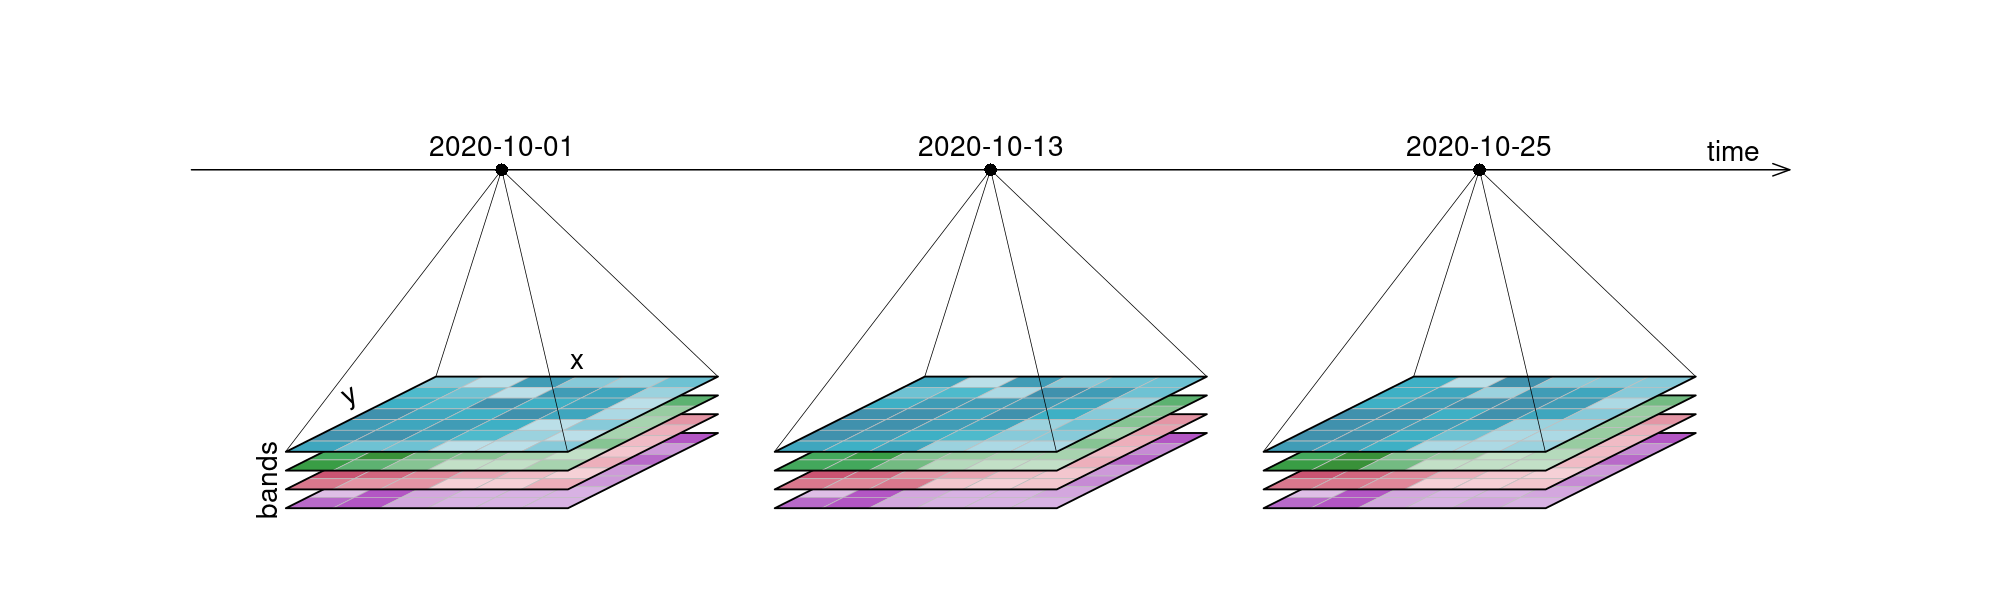

In [88]:
# Carrego a coleção para o período anterior ao deslizamento
datacube_before = connection.load_collection(
    "SENTINEL2_L2A", # selecionamos a coleção do sentinel2 L2A, porque são produtos de reflectãncia de superfície, com correção atmosférica. 
                     # A opção COPERNICUS/S2 (L1C): São produtos de reflectância no topo da atmosfera (TOA) sem correção atmosférica.
    spatial_extent=geom,
    temporal_extent=[before_start_date, landslide_date_str],
    bands=bands, #selecionei apenas as bandas necessárias pra aplicação da fórmula do NDVI
    max_cloud_cover=20, # defini o percentual de cobertura de nuvens de até 20%. isso é ajustável para cada caso.
)

# para selecionar a imagem imediatamente anterior ao deslizamento, faço sort por data em ordem decrescente e limito a 1
def get_latest_image(datacube):
    return datacube.reduce_dimension(dimension="t", reducer="last")

# a dimensão escolhida é t, porque ela é a dimensão temporal do nosso datacube

In [89]:
# O mesmo processo é feito para imagem imediatamente posterior ao deslizamento:
datacube_after = connection.load_collection(
    "SENTINEL2_L2A",
    spatial_extent=geom,
    temporal_extent=[landslide_date_str, after_end_date],
    bands=bands,
    max_cloud_cover=20,
)
# aqui ele seleciona a primeira imagem válida imediatamente após o deslizamento
def get_first_image(datacube):
    return datacube.reduce_dimension(dimension="t", reducer="first")

In [90]:
# aplicação das funções
datacube_before = get_latest_image(datacube_before)
datacube_after = get_first_image(datacube_after)

## Visualização do RGB e NDVI

### Para tal, vou criar um datacube contendo as imagens da data anterior e posterior ao deslizamento

In [91]:
datacube_before_after = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=(before_start_date, after_end_date), # aqui coloquei essas duas datas
    spatial_extent=geom,
    bands=["B04", "B03", "B02", "SCL", "B08"],
    max_cloud_cover=20,
)

In [92]:
# Vou baixar esse slice que defini da data em formato netCDF para uma inspeção inicial
datacube_before_after.download("load-datacube.nc")

#### Visualização do RGB

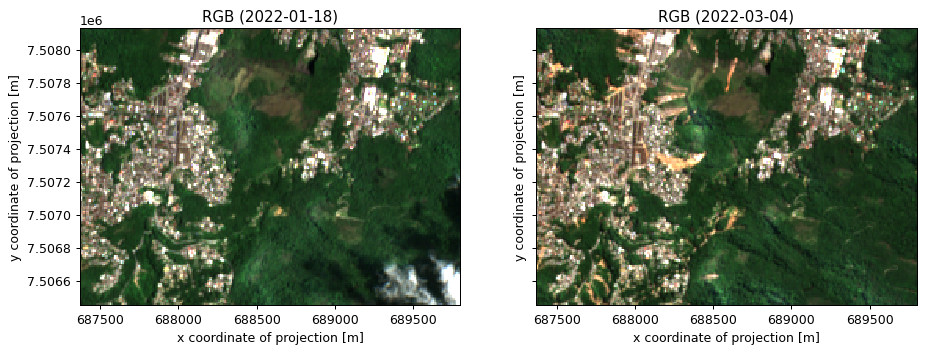

In [93]:
# Agora, é possível visualizar o dataset 

ds = xarray.load_dataset("load-datacube.nc")
# converto o dataset xarrat para (bands, t, x, y) dataArray
data = ds[["B04", "B03", "B02"]].to_array(dim="bands")

fig, axes = plt.subplots(ncols=2, figsize=(12, 4), dpi=90, sharey=True)
data[{"t": 0}].plot.imshow(vmin=0, vmax=2000, ax=axes[0])
axes[0].set_title(f"RGB ({ds['t'][0].values.astype('datetime64[D]')})") # mudança no título
data[{"t": -1}].plot.imshow(vmin=0, vmax=2000, ax=axes[1])
axes[1].set_title(f"RGB ({ds['t'][1].values.astype('datetime64[D]')})");


Com isso, é possível saber qual foi a data das imagens antes e após o deslizamento

In [94]:
timestamp_before = pd.to_datetime(ds.coords["t"].values[0])  # Data de t: 0 (Antes do Deslizamento)
timestamp_after = pd.to_datetime(ds.coords["t"].values[-1])  # Data de t: -1 (Após o Deslizamento)

#### Visualização do NDVI

In [95]:
# Calcular o NDVI para todas as datas
def calculate_ndvi(ds):
    nir = ds["B08"]  # Banda do infravermelho próximo
    red = ds["B04"]  # Banda do vermelho
    ndvi = (nir - red) / (nir + red)
    return ndvi

# aplico a função para calcular o NDVI
ndvi_data = calculate_ndvi(ds)

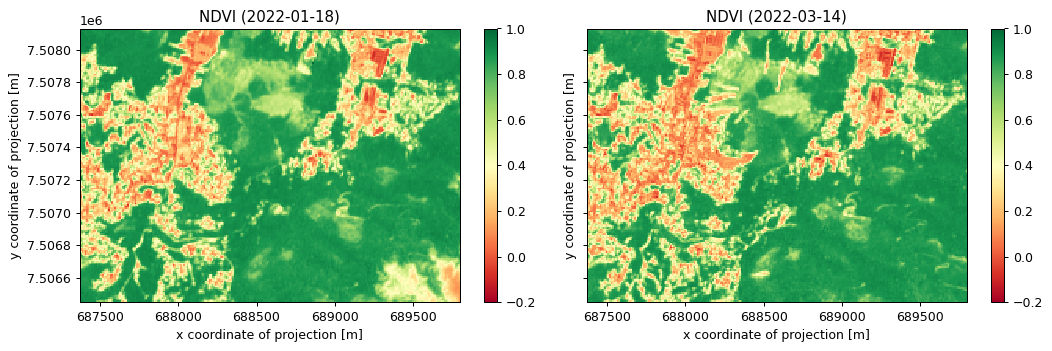

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4), dpi=90, sharey=True)

# personalizando os gráficos
# defini valor máximo 1 e mínimo -1, conforme fórmula do NDVI. Inseri o degradê através do colormap "RdY1Gn", que vai do vermelho ao verde

ndvi_data[{"t": 0}].plot.imshow(ax=axes[0],vmin=-0.2, vmax=1, cmap="RdYlGn", add_colorbar=True) 
axes[0].set_title(f"NDVI ({ds['t'][0].values.astype('datetime64[D]')})") # mudança no título

ndvi_data[{"t": -1}].plot.imshow(ax=axes[1], vmin=-0.2, vmax=1, cmap="RdYlGn", add_colorbar=True)
axes[1].set_title(f"NDVI ({ds['t'][-1].values.astype('datetime64[D]')})")

plt.tight_layout()
plt.show()

## Download das imagens RGB

### Como a coleção está trazendo todas as bandas, basta baixar a imagem em formato .tif e selecionar as bandas do RGB no QGIS: 
B04 - red  
B03 - green  
B02 - blue  
Fonte: https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/bands/

In [97]:
# Imagens RBG
output_path_before = f"{output_dir_RGB}/RGB_before_{timestamp_before.strftime('%Y%m%d')}.tif"
output_path_after = f"{output_dir_RGB}/RGB_after_{timestamp_after.strftime('%Y%m%d')}.tif"

In [98]:
# Faço o download das imagens no formato geotiff
datacube_before.download(output_path_before, format="GTiff")
datacube_after.download(output_path_after, format="GTiff")

## Download das imagens NDVI (Normalized Difference Vegetation Index)

In [99]:
# aplicação do NDVI (B08 - B04) / (B08 + B04)
def calc_ndvi(ndvi):
    return ndvi.apply(lambda pixel: (pixel["B08"] - pixel["B04"]) / (pixel["B08"] + pixel["B04"]))

# aplico a função para cada período
ndvi_before = calc_ndvi(datacube_before)
ndvi_after  = calc_ndvi(datacube_after)

In [100]:
# diretórios de saída para os arquivos TIFF
output_path_before = f"{output_dir_NDVI}/NDVI_before_{timestamp_before.strftime('%Y%m%d')}.tif"
output_path_after = f"{output_dir_NDVI}/NDVI_after_{timestamp_after.strftime('%Y%m%d')}.tif"

In [101]:
# Faço o download das imagens no formato geotiff
ndvi_before.download(output_path_before, format="GTiff")
ndvi_after.download(output_path_after, format="GTiff")

## Análise diferencial do NDVI

A análise diferencial do NDVI revela a perda de vegetação na área afetada pelo deslizamento. 

Se quisermos verificar o efeito da perda de vegetação, podemos calcular o diferencial NDVI (Δ NDVI) subtraindo a matriz NDVI pré-deslizamento da matriz pós-deslizamento.

In [ ]:
# Vou carregar os arquivos  GeoTIFF que gerei

ndvi_before = rio.open_rasterio("./sentinel2_10m/NDVI/NDVI_before_20220118.tif")
ndvi_after = rio.open_rasterio("./sentinel2_10m/NDVI/NDVI_after_20220314.tif")

In [65]:
# Faço a subtração do posterior com o anterior
ndvi_diff = ndvi_after  - ndvi_before 

In [66]:
# Gero um geotiff com isso
ndvi_diff.rio.to_raster("./sentinel2_10m/NDVI/NDVI_difference.tif")

Como o ndvi_diff é um datacube, ele tem uma dimensão band de tamanho 1. Para remover essa dimensão, uso .squeeze()

In [68]:
ndvi_diff = ndvi_diff.squeeze("band", drop=True)

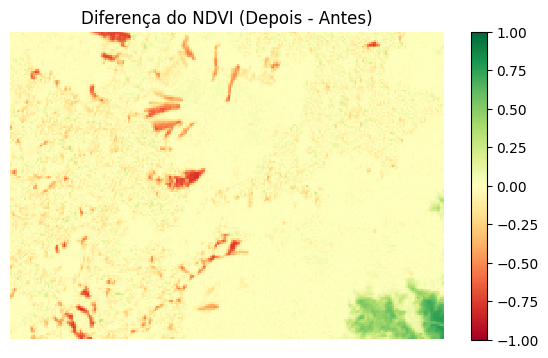

In [96]:
# Plotagem da diferença
plt.figure(figsize=(7, 4))
ndvi_diff.plot.imshow(
    cmap="RdYlGn",  # Colormap para destacar mudanças
    vmin=-1,        # Valores mínimos do NDVI
    vmax=1,         # Valores máximos do NDVI
    add_colorbar=True,
)
plt.title("Diferença do NDVI (Depois - Antes)")
plt.axis('off')  # Remover eixos
plt.show()

### Agora, eu quero gerar uma visualização em que meu dado só tem valores de NDVI abaixo de -0.1, o que irá indicar as perdas de vegetação por deslizamento


In [134]:
# Gero um binário, em que valores abaixo de -0.1 eu tenho 0, e valores acima disso, eu tenho 1.
ndvi_binary = ndvi_diff.where(ndvi_diff > -0.1, 0).where(ndvi_diff <= -0.1, 1)

In [135]:
# Download do geotiff
ndvi_binary.rio.to_raster("./sentinel2_10m/NDVI/ndvi_binary.tif")

gerando o binário, basta eu classificar no QGIS e visualizar apenas os valores em que ndvi_diff < -0.1

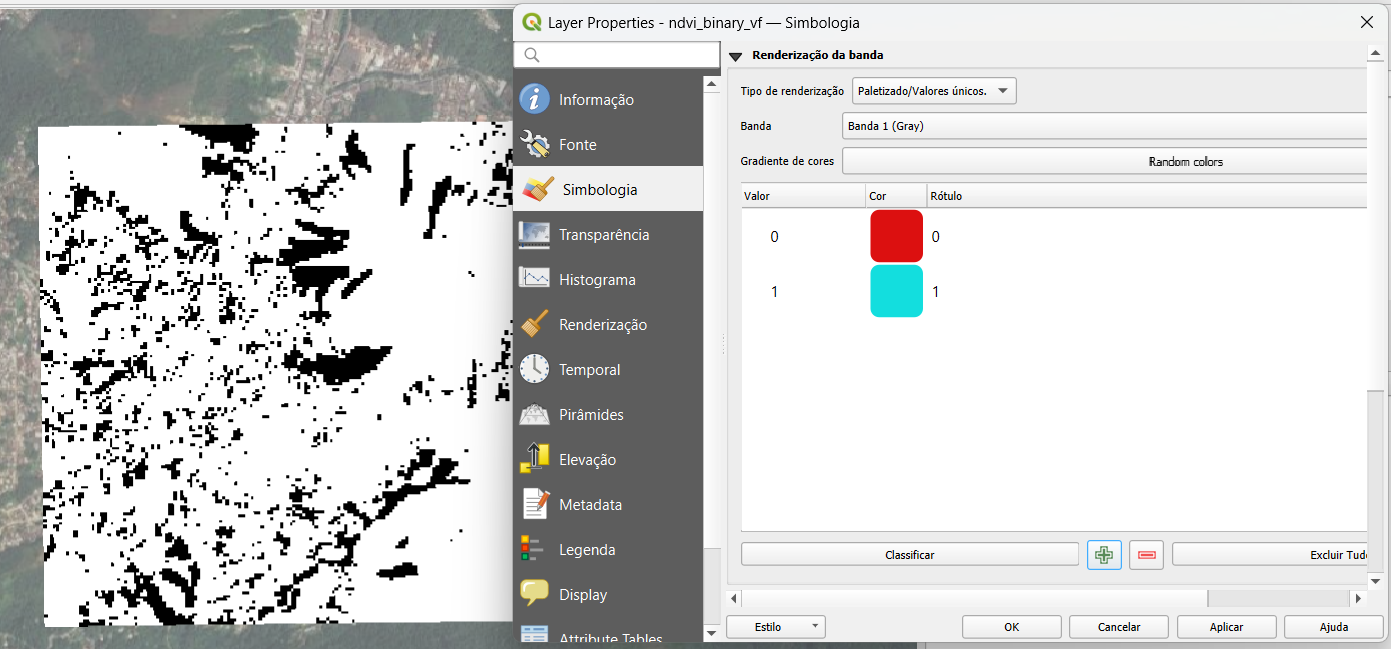

Se eu removo o 1 (cor branca no mapa) e deixo apenas o 0 (cor preta no mapa), consigo visualizar as áreas com vegetação afetada pelo deslizamento

### Visualização do resultado 


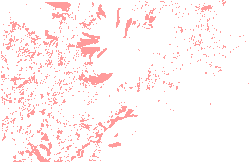

In [136]:
# Carrego o arquivo binário NDVI
ndvi_binary = rio.open_rasterio("/home/andre/Documentos/veg_index/sentinel2_10m/NDVI/ndvi_binary.tif")

# faço a remoção de dimensão band, deixando apenas x/y
ndvi_binary = ndvi_binary.squeeze("band", drop=True)

# reprojeto para EPSG: 4326
if ndvi_binary.rio.crs != "EPSG:4326":
    ndvi_binary = ndvi_binary.rio.reproject("EPSG:4326")

# faço a obtenção dos bounds geográficos do arquivo
bounds = [
    [ndvi_binary.y.min().item(), ndvi_binary.x.min().item()],  # SW (lat, lon)
    [ndvi_binary.y.max().item(), ndvi_binary.x.max().item()],  # NE (lat, lon)
]

# crio uma máscara binária, garantindo que só irei destacar os valores 0 (houve deslizamento), pois todos os valores que não são 0 serão substituídos por 1.
mask = ndvi_binary.where(ndvi_binary == 0, 1).values  

# - Transparente para 1
# - Vermelho semi-transparente para 0
colormap = np.zeros((*mask.shape, 4), dtype=np.uint8)  # Matriz RGBA (sendo o A = Alpha = transparência, que vai de 0 a 255)
colormap[mask == 0] = [255, 0, 0, 100]  # Vermelho com 40% de opacidade (RGBA: 255,0,0, alpha = 100/255 = 0.4)

# crio um mapa interativo usando Google Satellite como basemap
mapa = folium.Map(
    location=[(bounds[0][0] + bounds[1][0]) / 2, (bounds[0][1] + bounds[1][1]) / 2],  # defino o centro
    zoom_start=14, # o zoom começa em 14, mas isso é de acordo com a preferência
    tiles="https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",  # conexão com o google Satellite
    attr="Google",
)

# coloco a máscara de deslizamento como overlay (basta clicar no ícone de camadas no canto superior direito)
ImageOverlay(
    image=colormap,
    bounds=bounds,
    name="Áreas de Deslizamento",
    opacity=1,  # como já defini a opacidade de 40% para o vermelho acima, deixei esse como 100%
).add_to(mapa)

# adiocionei o controle de camadas 
folium.LayerControl().add_to(mapa)

mapa # exibo logo abaixo